In [ ]:
import numpy as np
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from google.colab.data_table import DataTable
DataTable.max_columns = 400
import statsmodels.api as sm
import numpy as np
import json
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from torchvision import transforms, models
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
# @title Set seed for reproducability

SEED = 1
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 1 has been set.
GPU is enabled in this notebook.


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/CIS 522/code/input/TikTok Data/fyp_1650166896697_with_virality.csv')
df = df.drop(columns=["Unnamed: 0"])
print(df.label.value_counts())
df

0    506
1    469
Name: label, dtype: int64


,id,caption_pp,author_verification,authorMeta.following,authorMeta.fans,authorMeta.heart,authorMeta.video,authorMeta.digg,music_original,musicMeta.duration,...,effect_Sticker su schermo verde,effect_Shapeshifting,effect_Vintage DV,effect_Mega Mouth,effect_Color Customizer,effect_Outline,effect_Color Selector,effect_Greenscreen,effect_Scrolling Text,label
0,6862153058223197445,18,1,589,89100000,2100000000,458,8327,0,10,...,0,0,0,0,0,0,0,0,0,0
1,6911406868699073798,69,1,99,11800000,233100000,193,27800,0,34,...,0,0,0,0,0,0,0,0,0,0
2,7028775404173413678,35,0,166,987000,40400000,3,8148,1,13,...,0,0,0,0,0,0,0,0,0,1
3,6975140587196517638,94,0,51,13300000,171800000,443,9341,1,24,...,0,0,0,0,0,0,0,0,0,0
4,6984473039605959941,24,0,9861,2900000,39000000,1093,15600,1,11,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,6889900644510059781,126,0,9948,1100000,13900000,263,55400,0,60,...,0,0,0,0,0,0,0,0,0,1
971,6814512525250530566,146,0,395,1600000,38400000,1025,74900,0,15,...,0,0,0,0,0,0,0,0,0,1
972,6983419881379155206,33,0,155,4400000,106700000,618,14600,1,91,...,0,0,0,0,0,0,0,0,0,0
973,6820442532665707782,46,1,376,9200000,223600000,600,353,1,10,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
class TikTokDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.input_size = (1920,1080)
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(self.input_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df['id'])

    def __getitem__(self, idx):
        image_folder = "/content/drive/Shareddrives/CIS 522/code/input/TikTok Data/batch_4_100000/"
        image = Image.open("{}/{}.png".format(image_folder, self.df.loc[idx]['id'])).convert('RGB')
        img = self.transform(image)
        label = self.df.loc[idx]['label']
        return img, label

In [ ]:
test_size = 0.2
train_df = df.sample(frac=1-test_size)
test_df = df.drop(train_df.index)
train_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True,drop=True)

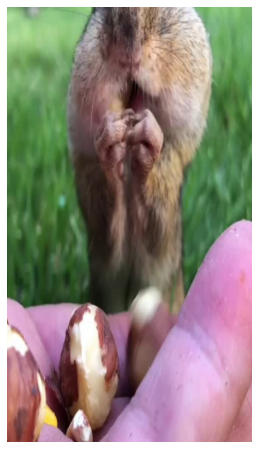

In [ ]:
# To preserve reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)
batch_size = 32

# Load data
train_loader = DataLoader(TikTokDataset(train_df),
                          num_workers=0, 
                          batch_size=32,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed)
test_loader = DataLoader(TikTokDataset(test_df), 
                         num_workers=0, 
                         batch_size=1,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

dataiter = iter(test_loader)
images, labels = dataiter.next()

# Show images
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2)
        self.pool2 = nn.MaxPool2d(4, 4)
        
        self.drop_out = nn.Dropout(0.3)

        self.fc1 = nn.Linear(14848, 10024)
        self.fc2 = nn.Linear(10024, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 32)
        self.fc5 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop_out(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
num_epochs = 10

In [ ]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
        if (i + 1) % 5 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/50], Step [5/25], Loss: 9.2972, Accuracy: 46.88%
Epoch [1/50], Step [10/25], Loss: 0.7011, Accuracy: 46.88%
Epoch [1/50], Step [15/25], Loss: 0.6844, Accuracy: 59.38%
Epoch [1/50], Step [20/25], Loss: 0.7108, Accuracy: 40.62%
Epoch [1/50], Step [25/25], Loss: 0.6932, Accuracy: 50.00%
Epoch [2/50], Step [5/25], Loss: 0.6925, Accuracy: 65.62%
Epoch [2/50], Step [10/25], Loss: 0.6776, Accuracy: 71.88%
Epoch [2/50], Step [15/25], Loss: 0.6810, Accuracy: 59.38%
Epoch [2/50], Step [20/25], Loss: 0.6669, Accuracy: 65.62%
Epoch [2/50], Step [25/25], Loss: 0.7118, Accuracy: 41.67%
Epoch [3/50], Step [5/25], Loss: 0.6971, Accuracy: 46.88%
Epoch [3/50], Step [10/25], Loss: 0.6921, Accuracy: 53.12%
Epoch [3/50], Step [15/25], Loss: 0.6963, Accuracy: 46.88%
Epoch [3/50], Step [20/25], Loss: 0.6920, Accuracy: 56.25%
Epoch [3/50], Step [25/25], Loss: 0.7164, Accuracy: 33.33%
Epoch [4/50], Step [5/25], Loss: 0.6863, Accuracy: 56.25%
Epoch [4/50], Step [10/25], Loss: 0.6914, Accuracy: 53.12%
E

[0.6962068676948547, 0.6966681480407715, 0.6801533102989197, 0.6878213286399841, 0.7011315226554871, 0.7015923261642456, 0.6849347352981567, 0.714156985282898, 0.6897010207176208, 0.6844195127487183, 0.6875719428062439, 0.6871861815452576, 0.6867651343345642, 0.7062864899635315, 0.7107792496681213, 0.7119147181510925, 0.6914274096488953, 0.6932471990585327, 0.6984896659851074, 0.6931504607200623, 0.6926833987236023, 0.6984791159629822, 0.6923959851264954, 0.6938257813453674, 0.6925407648086548, 0.6950825452804565, 0.691093921661377, 0.690268874168396, 0.7007014751434326, 0.6776143908500671, 0.6880850791931152, 0.6951560974121094, 0.7046906352043152, 0.6585299968719482, 0.6809597611427307, 0.7088375091552734, 0.685750424861908, 0.6981029510498047, 0.7237213253974915, 0.6669474244117737, 0.6981548070907593, 0.6980555653572083, 0.7039123773574829, 0.6974912881851196, 0.71183842420578, 0.6964638233184814, 0.6866647005081177, 0.6995362639427185, 0.7020668983459473, 0.6970788836479187, 0.693

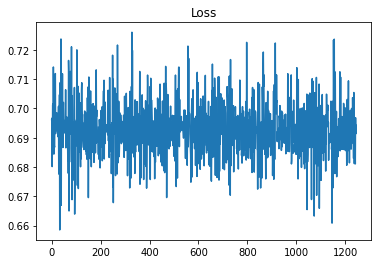

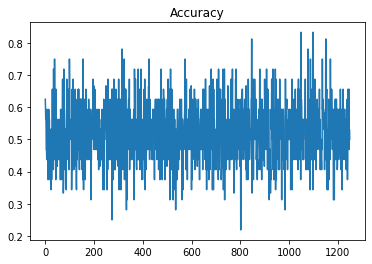

In [ ]:
plt.title("Loss")
plt.plot(range(0, len(loss_list[5::])), loss_list[5::])
print(loss_list[5::])
plt.show()
plt.title("Accuracy")
plt.plot(range(0, len(acc_list)), acc_list)

In [ ]:
# Test the model
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))


Test Accuracy of the model on the test images: 50.256410256410255 %
